# Part 1: Exploratory Data Analysis
<b>Author</b>: Sterling Cutler
<br>
<b>Date</b>: March 20, 2018

## Introduction to Ratemaking
Insurance companies use pricing (or ratemaking) models to determine premiums rates. A rate is an estimate of the expected value of a future cost. In insurance, rates are used to cover the expected cost of loss events. There are three primary regulations governing how insurers set these rates:

1.) they must be *fair* compared to the risk

2.) they must be *adequate* to maintain insurer solvency

3.) they are *not discriminatory* against members of an underwriting class with similar risk profiles

Another important consideration in designing models is the interpretability and underlying statistical basis on which it operates. A Casualty Actuarial and Statistical Task Force White Paper[1] states, "The Task Force recommends that rating plans in which insureds are grouped into homogeneous rating classes should not be so granular that resulting rating classes have little actuarial or statistical reliability. The use of sophisticated data analysis to develop finely tuned methodologies with a multiplicity of possible rating cells is not, in and of itself, a violation of rating laws as long as the rating classes and rating factors are cost-based."

Given the various constraints imposed on insurance modeling, generalized linear models are frequently used. This report will demonstrate examples of using linear models to interpret and predict auto bodily injury losses. The dataset is provided in the "insuranceData" package.

Description of the variables[3] are as follows: 
- CASENUM: case number to identify the claim
- ATTORNEY: whether the claimant is represented by an attorney (=1 if yes and =2 if no)
- CLMSEX: claimant's gender (=1 if male and =2 if female)
- MARITAL: claimant's marital status (=1 if married, =2 if single, =3 if widowed, and =4 if divorced/separated)
- CLMINSUR: whether or not the driver of the claimant's vehicle was uninsured (=1 if yes, =2 if no, and =3 if not applicable)
- SEATBELT: whether or not the claimant was wearing a seatbelt/child restraint (=1 if yes, =2 if no, and =3 if not applicable)
- CLMAGE: claimant's age
- LOSS The claimant's total economic loss (in thousands)

In [1]:
# Load packages
library(insuranceData)

# Load dataset
data(AutoBi)

## Exploratory Data Analysis (EDA)
Before applying a model to a dataset, it's important to conduct exploratory data analysis to understand the distribution and relationships between the indepedent and dependent variables. Data Scientist Daniel Gutierrez explains[2], "The goal of exploratory data analysis is to obtain confidence in your data to a point where you're ready to engage a machine learning algorithm...In a hurry to get to the machine learning stage, some data scientists either entirely skip the exploratory process or do a very perfunctory job. This is a mistake with many implications, including generating inaccurate models, generating accurate models but on the wrong data, not creating the right types of variables in data preparation, and using resources inefficiently because of realizing only after generating models that perhaps the data is skewed, or has outliers, or has too many missing values, or finding that some values are inconsistent."

We'll start by examining the structure of the data including value types and distributions, as well as missing value counts and replacements. Because four of the five columns with missing values are categorical, and thereby coded as integers, we'll replace missing values with the column median. We'll remove an outlier ($1067.70) from the target variable and take the log distribution to keep it in scale with the other variables. We'll also normalize the claim age variable.

In [2]:
# Print dataset shape
cat('Shape:', dim(AutoBi))

Shape: 1340 8

In [3]:
# Print all variable names
cat('Variables:', names(AutoBi))

Variables: CASENUM ATTORNEY CLMSEX MARITAL CLMINSUR SEATBELT CLMAGE LOSS

In [4]:
# Print dataset structure
str(AutoBi)

'data.frame':	1340 obs. of  8 variables:
 $ CASENUM : int  5 13 66 71 96 97 120 136 152 155 ...
 $ ATTORNEY: int  1 2 2 1 2 1 1 1 2 2 ...
 $ CLMSEX  : int  1 2 1 1 1 2 1 2 2 1 ...
 $ MARITAL : int  NA 2 2 1 4 1 2 2 2 2 ...
 $ CLMINSUR: int  2 1 2 2 2 2 2 2 2 2 ...
 $ SEATBELT: int  1 1 1 2 1 1 1 1 1 1 ...
 $ CLMAGE  : int  50 28 5 32 30 35 19 34 61 NA ...
 $ LOSS    : num  34.94 10.892 0.33 11.037 0.138 ...


In [5]:
# Print first six rows of dataset
head(AutoBi)

CASENUM,ATTORNEY,CLMSEX,MARITAL,CLMINSUR,SEATBELT,CLMAGE,LOSS
5,1,1,NA,2,1,50,34.940
13,2,2,2,1,1,28,10.892
66,2,1,2,2,1,5,0.330
71,1,1,1,2,2,32,11.037
96,2,1,4,2,1,30,0.138
97,1,2,1,2,1,35,0.309


Next, we'll inspect missing value counts. Because four of the five columns with missing values are categorical, and thereby coded as integers, we'll replace missing values with the column median.

In [6]:
# Examine current count of missing values
nulls <- sapply(AutoBi, function(col) sum(is.na(col)))
print(nulls)

 CASENUM ATTORNEY   CLMSEX  MARITAL CLMINSUR SEATBELT   CLMAGE     LOSS 
       0        0       12       16       41       48      189        0 


In [7]:
# Replace missing values with column median
for(i in 1:ncol(AutoBi)){
  AutoBi[is.na(AutoBi[,i]), i] <- median(AutoBi[,i], na.rm = TRUE)
}
print(nulls)

 CASENUM ATTORNEY   CLMSEX  MARITAL CLMINSUR SEATBELT   CLMAGE     LOSS 
       0        0       12       16       41       48      189        0 


We'll normalize the claim age variable, remove an outlier ($1067.70) from the target variable and take the log distribution to keep it in scale with the other variables.

In [8]:
# Normalize claim age variable
AutoBi$NORM_CLMAGE <- (AutoBi$CLMAGE-mean(AutoBi$CLMAGE))/sd(AutoBi$CLMAGE)
summary(AutoBi$NORM_CLMAGE)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.03936 -0.71407 -0.08298  0.00000  0.54811  3.95599 

In [9]:
# Remove outlier from target loss variable
summary(AutoBi$LOSS)
AutoBi <- subset(AutoBi, LOSS < 300)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.005    0.640    2.331    5.954    3.995 1067.697 

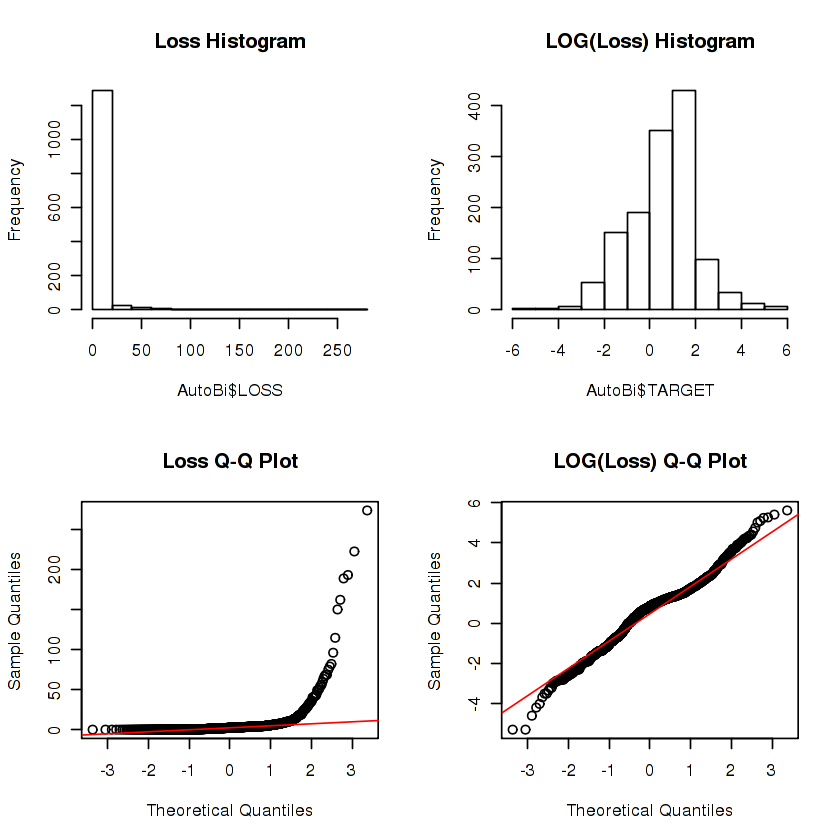

In [10]:
# Take log distribution of target loss variable and visualize
AutoBi$TARGET <- with(AutoBi, log(LOSS))
par(mfrow=c(2, 2))
hist(AutoBi$LOSS, main="Loss Histogram")
hist(AutoBi$TARGET, main="LOG(Loss) Histogram")
qqnorm(AutoBi$LOSS, main="Loss Q-Q Plot")
qqline(AutoBi$LOSS, col='red')
qqnorm(AutoBi$TARGET, main="LOG(Loss) Q-Q Plot")
qqline(AutoBi$TARGET, col='red')

We'll ignore the case number variable and the loss and claim age variables before transformation. We'll plot the histograms and boxplots of the remaining variables to inspect their distributions.

In [11]:
# Select columns for modeling and print summary
data <- AutoBi[, -c(1, 7, 8)]
summary(data)

    ATTORNEY         CLMSEX         MARITAL         CLMINSUR       SEATBELT    
 Min.   :1.000   Min.   :1.000   Min.   :1.000   Min.   :1.00   Min.   :1.000  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:2.00   1st Qu.:1.000  
 Median :1.000   Median :2.000   Median :2.000   Median :2.00   Median :1.000  
 Mean   :1.489   Mean   :1.562   Mean   :1.598   Mean   :1.91   Mean   :1.016  
 3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.000   3rd Qu.:2.00   3rd Qu.:1.000  
 Max.   :2.000   Max.   :2.000   Max.   :4.000   Max.   :2.00   Max.   :2.000  
  NORM_CLMAGE            TARGET       
 Min.   :-2.039360   Min.   :-5.2983  
 1st Qu.:-0.714073   1st Qu.:-0.4463  
 Median :-0.082984   Median : 0.8450  
 Mean   : 0.000062   Mean   : 0.5520  
 3rd Qu.: 0.548106   3rd Qu.: 1.3847  
 Max.   : 3.955987   Max.   : 5.6117  

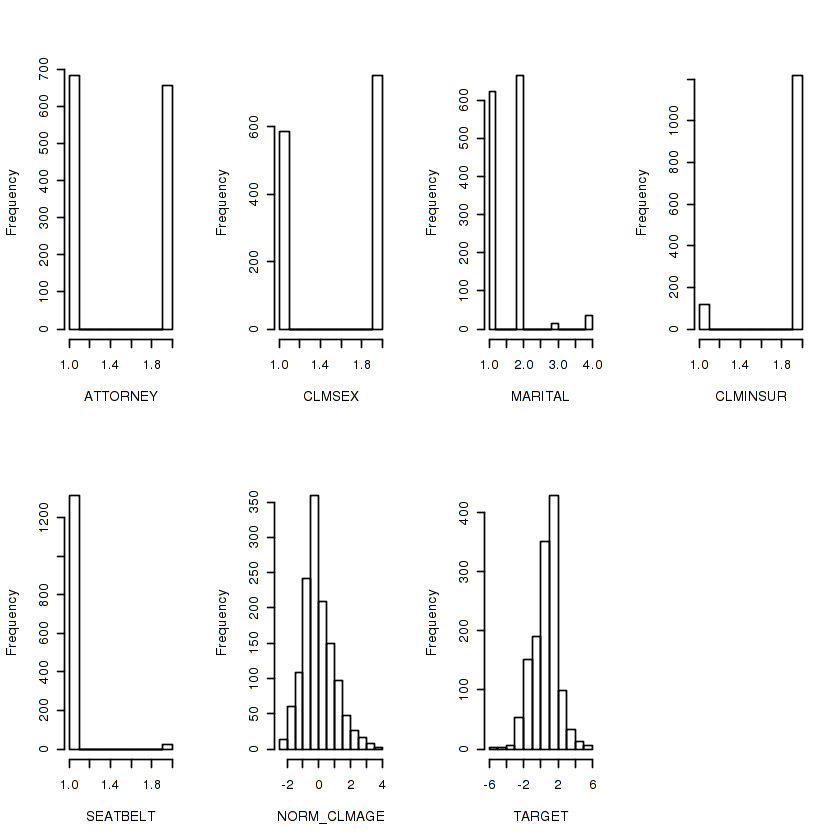

In [12]:
# Plot histograms
par(mfrow=c(2, 4))
for (i in c(1:length(data))){
  hist(data[, i], xlab=paste(names(data)[i]), main="")
}

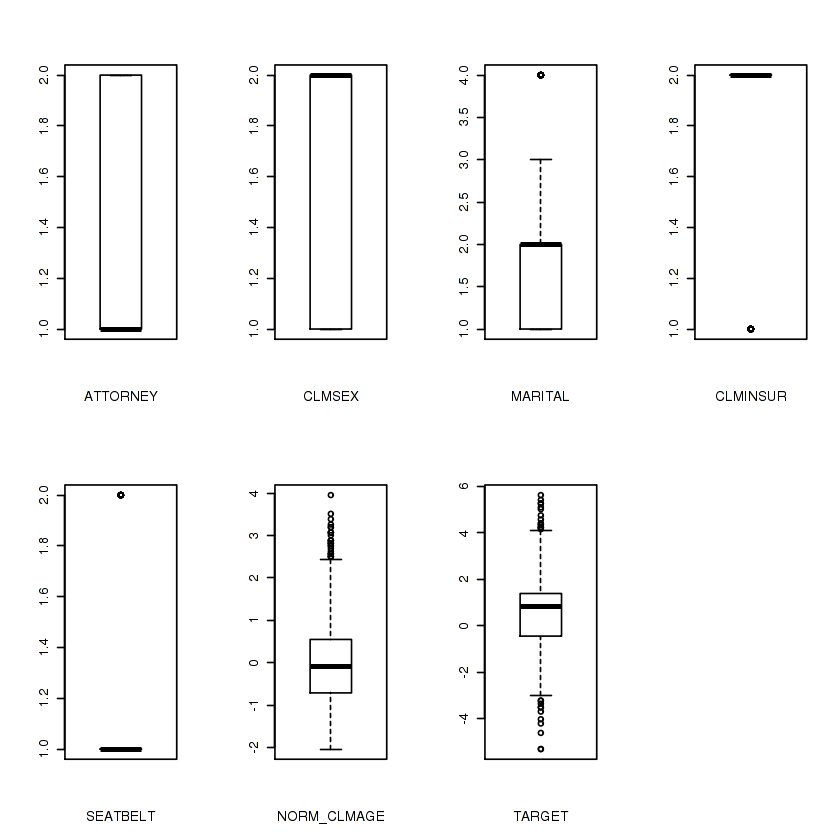

In [13]:
# Plot boxplots
par(mfrow=c(2, 4))
for (i in c(1:length(data))){
  boxplot(data[, i], xlab=paste(names(data)[i]), main="")
}

ggplot is a great R package for visualizing the interactions between multiple variables like so:

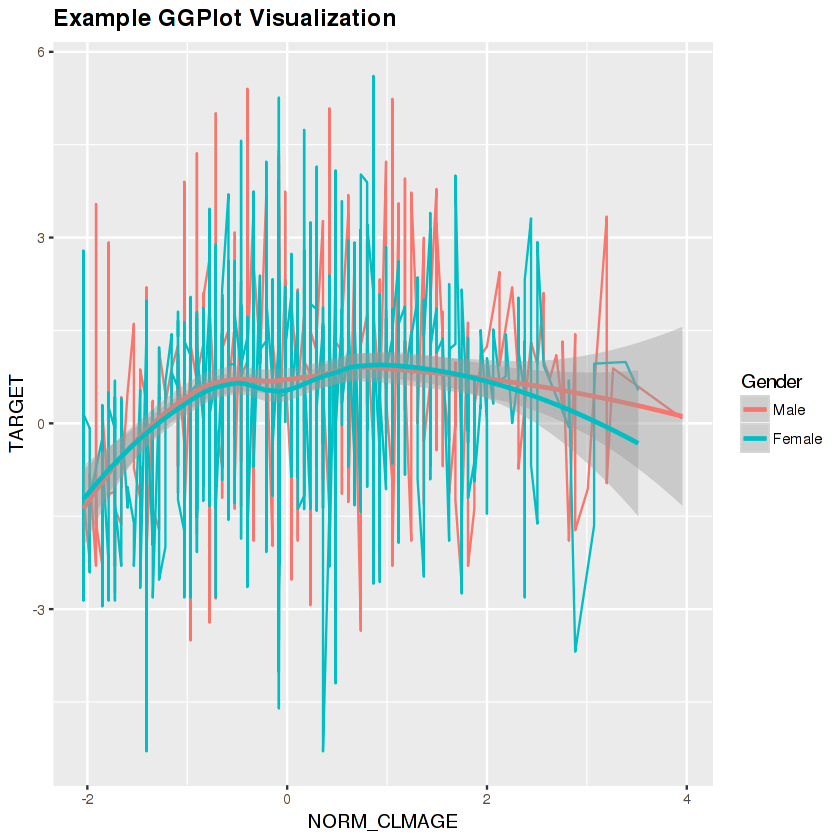

In [14]:
library(ggplot2)

# Demonstrate example of ggplot for claim sex, claim age, and target loss
p <- ggplot(data=data, aes(x=NORM_CLMAGE, y=TARGET, group=CLMSEX)) + 
  geom_line(aes(color=factor(CLMSEX))) + 
  geom_smooth(aes(color=factor(CLMSEX)), method="loess") +
  scale_colour_discrete(name="Gender", labels=c("Male", "Female")) + 
  ggtitle("Example GGPlot Visualization") +
  theme(plot.title = element_text(size=14, face="bold"))
p

## Statistical Analysis
Before moving on, it's important to examine the correlations, variances, and covariances between the variables to understand their relationships with each other.

In [16]:
# Print matrices of variable correlations, variances, and covariances
cor(data)
var(data)
cov(data)

,ATTORNEY,CLMSEX,MARITAL,CLMINSUR,SEATBELT,NORM_CLMAGE,TARGET
ATTORNEY,1.000000000,0.07725816,-0.004211485,0.07689041,-0.05596228,0.01217038,-0.48060306
CLMSEX,0.077258165,1.00000000,0.019869566,0.06579117,-0.01624646,-0.01395414,-0.02122892
MARITAL,-0.004211485,0.01986957,1.000000000,0.02335017,-0.01959518,-0.24986330,-0.08583131
CLMINSUR,0.076890411,0.06579117,0.023350171,1.00000000,0.01998392,0.03430618,-0.03274251
SEATBELT,-0.055962277,-0.01624646,-0.019595180,0.01998392,1.00000000,-0.02074376,0.11050440
NORM_CLMAGE,0.012170385,-0.01395414,-0.249863297,0.03430618,-0.02074376,1.00000000,0.16918624
TARGET,-0.480603060,-0.02122892,-0.085831307,-0.03274251,0.11050440,0.16918624,1.00000000


,ATTORNEY,CLMSEX,MARITAL,CLMINSUR,SEATBELT,NORM_CLMAGE,TARGET
ATTORNEY,0.250069492,0.019173557,-0.001364716,0.0109869378,-0.0035588659,0.006088296,-0.35295392
CLMSEX,0.019173557,0.246295174,0.006389883,0.0093297432,-0.0010253508,-0.006927749,-0.01547238
MARITAL,-0.001364716,0.006389883,0.419907099,0.0043235532,-0.0016147740,-0.161972091,-0.08168145
CLMINSUR,0.010986938,0.009329743,0.004323553,0.0816485095,0.0007261739,0.009806356,-0.01374001
SEATBELT,-0.003558866,-0.001025351,-0.001614774,0.0007261739,0.0161722991,-0.002638970,0.02063795
NORM_CLMAGE,0.006088296,-0.006927749,-0.161972091,0.0098063562,-0.0026389697,1.000742234,0.24855774
TARGET,-0.352953919,-0.015472376,-0.081681453,-0.0137400137,0.0206379509,0.248557737,2.15676210


,ATTORNEY,CLMSEX,MARITAL,CLMINSUR,SEATBELT,NORM_CLMAGE,TARGET
ATTORNEY,0.250069492,0.019173557,-0.001364716,0.0109869378,-0.0035588659,0.006088296,-0.35295392
CLMSEX,0.019173557,0.246295174,0.006389883,0.0093297432,-0.0010253508,-0.006927749,-0.01547238
MARITAL,-0.001364716,0.006389883,0.419907099,0.0043235532,-0.0016147740,-0.161972091,-0.08168145
CLMINSUR,0.010986938,0.009329743,0.004323553,0.0816485095,0.0007261739,0.009806356,-0.01374001
SEATBELT,-0.003558866,-0.001025351,-0.001614774,0.0007261739,0.0161722991,-0.002638970,0.02063795
NORM_CLMAGE,0.006088296,-0.006927749,-0.161972091,0.0098063562,-0.0026389697,1.000742234,0.24855774
TARGET,-0.352953919,-0.015472376,-0.081681453,-0.0137400137,0.0206379509,0.248557737,2.15676210


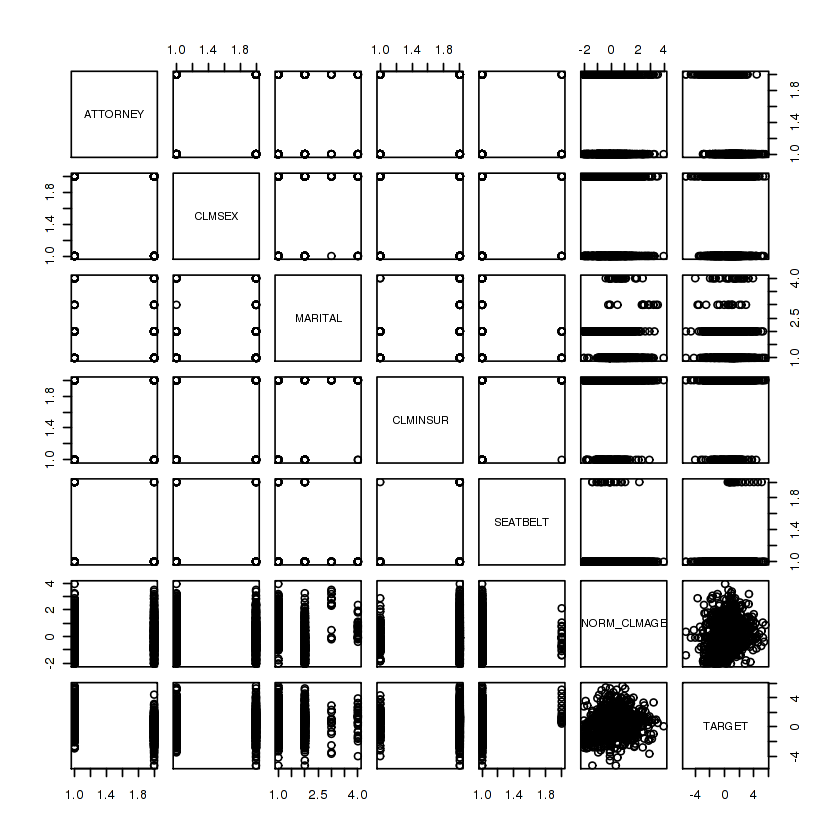

In [17]:
# Plot scatterplot matrix
pairs(data)

We'll also use the VIF test to detect if any multicollinearity is present. We can conclude multicollinearity is not a major concern as the maximum VIF values are less than 10. Finally, we'll save the dataset to a CSV file for later use.

In [ ]:
# Calculate VIF values
library(VIF)

vifs <- vif(data$TARGET, data[1:6])
vif_df <- as.data.frame(vifs$modelmatrix)
names(vif_df) <- vifs$select
cat("Max VIF Values:/n", sapply(vif_df, max))

# Save data to CSV
write.csv(data, file="ABI_data.csv", row.names=FALSE)

## Sources
[1] http://www.naic.org/documents/committees_c_catf_related_price_optimization_white_paper.pdf

[2] https://insidebigdata.com/2014/11/09/ask-data-scientist-importance-exploratory-data-analysis/

[3] https://cran.r-project.org/web/packages/insuranceData/insuranceData.pdf